In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp, torch, sklearn
import rpy2, rpy2.situation, anndata2ri
from localization import * #Wavelet module

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/home/fc489/yaleCollab


In this notebook we will compute a wavelet dictionary on the KGnn v2

# Data ingestion

## Load scRNAseq data

In [3]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

In [4]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython

In [5]:
%%R -i data_dir -o dRnaSeq,dPHATEcoord
library(tidyverse)
library(Seurat)

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dPHATEcoord = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


AxisArrays with keys: 
Before filtering we have 20867 genes
After filtering genes expressed in fewer than 4 cells we have 20666


AnnData object with n_obs × n_vars = 3698 × 20666
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    var: 'n_cells'
    obsm: 'X_PHATE'
    layers: 'logcounts'

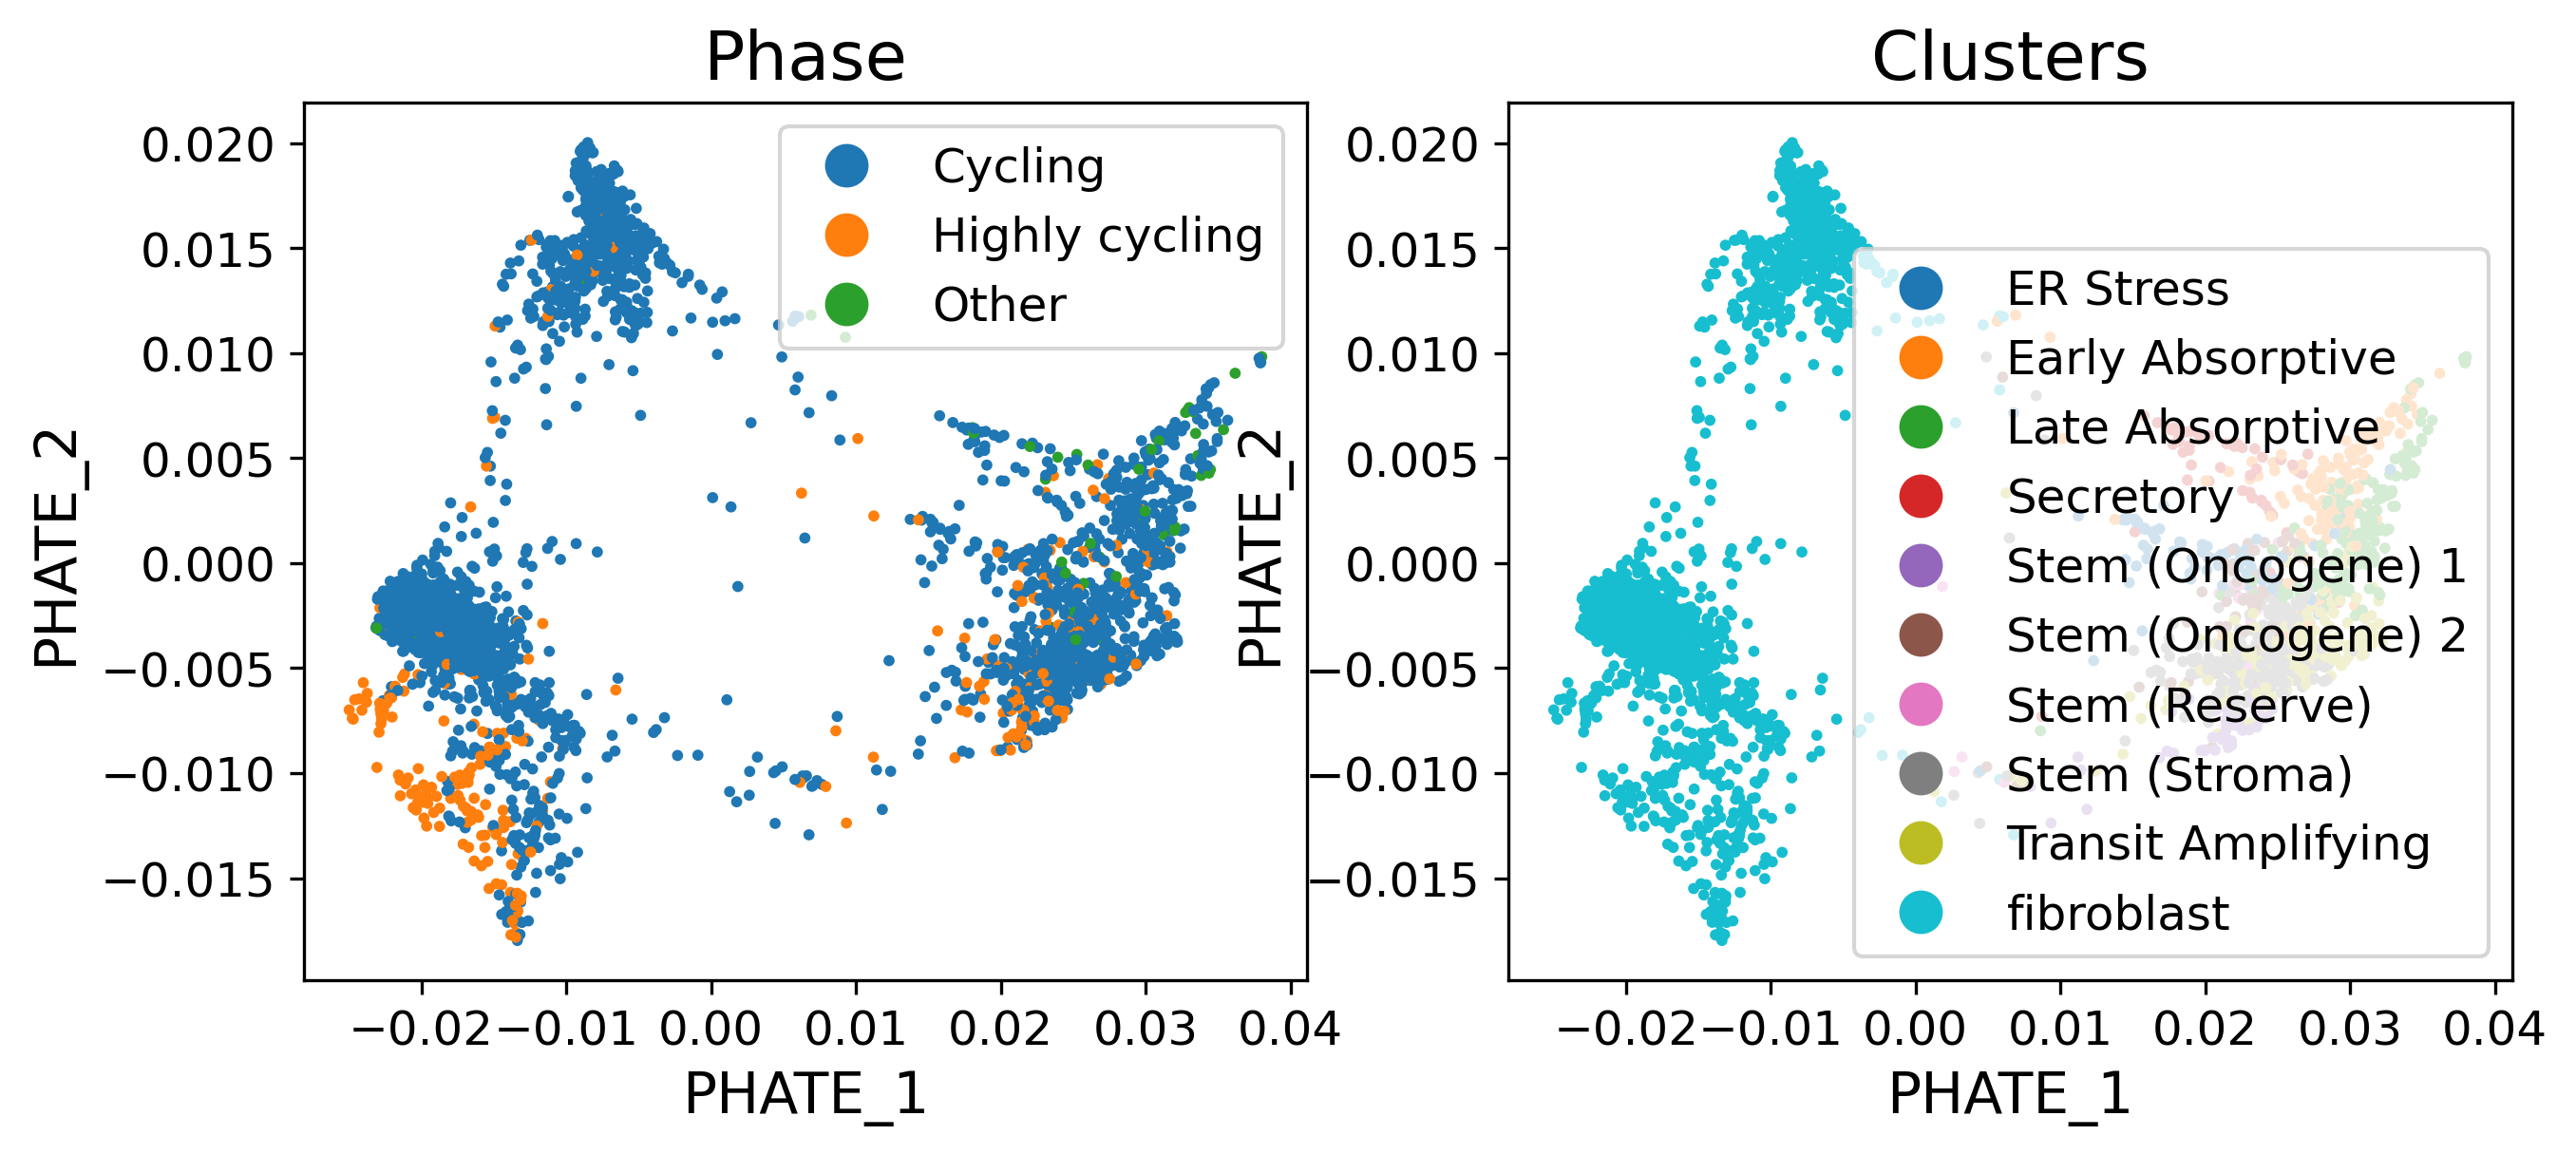

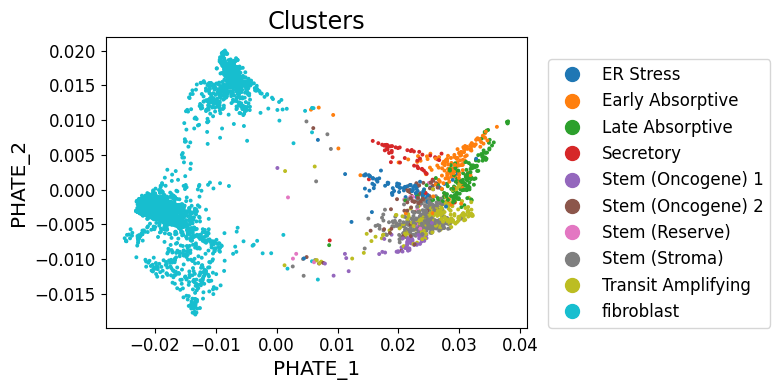

In [6]:
print(dRnaSeq.obsm)#No DimRed were ported over
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dPHATEcoord
del dPHATEcoord

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
    title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
    title=f"Clusters", ax=ax[1])

scprep.plot.scatter2d(
    dRnaSeq.obsm["X_PHATE"], 
    c=dRnaSeq.obs.finalPOPS, 
    title=f"Clusters", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8,4), dpi=480)

print(f"Before filtering we have {len(dRnaSeq.var_names)} genes")
scanpy.pp.filter_genes(dRnaSeq, min_cells=4, inplace=True)
print(f"After filtering genes expressed in fewer than 4 cells we have {len(dRnaSeq.var_names)}")

dRnaSeq

## Process data to human
Convert SEQ data to HGNC symbols

In [7]:
from biomart import BiomartServer

mart = BiomartServer("http://useast.ensembl.org/biomart").datasets["mmusculus_gene_ensembl"]
# mart.show_attributes()
# for i in mart.show_attributes_by_page():
#     print(i)

response = mart.search({"attributes":["external_gene_name",
            "hsapiens_homolog_associated_gene_name"]})

mouse2human = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        mouse2human.append(line)
mouse2human = pd.DataFrame(mouse2human, 
                columns=["mgi_symbol","hgnc_symbol"]
                ).drop_duplicates() 
mouse2human = mouse2human.set_index("mgi_symbol"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)


In [8]:
dSEQmd = dRnaSeq.obs
dRnaSeq = dRnaSeq.to_df(layer="logcounts").rename(columns=mouse2human).drop(
            columns=[""])
#After conversion some columns get duplicated. Group by them and average their gene expression
dRnaSeq = dRnaSeq.groupby(by=dRnaSeq.columns, axis=1).mean()
dRnaSeq

,0610010F05Rik,1110008P14Rik,1110012L19Rik,1300017J02Rik,1500009C09Rik,1700015F17Rik,1700020D05Rik,1700030C10Rik.1,1810026B05Rik,2010300C02Rik,...,ZYX,ZZEF1,ZZZ3,Zfp91.1,Zkscan7.1,Znrd1,Znrd1as,n-R5-8s1,pEGFP,partDsRedE
WT__AAACCCACAGCTTCCT-1,0.0,1.050319,0.000000,0.0,0.0,0.0,0.0,0.0,0.657148,0.0,...,0.657148,0.657148,0.657148,0.000000,0.0,1.050319,0.657148,0.0,0.0,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.498218,0.000000,0.0,0.0,0.0,0.0,0.0,0.498218,0.0,...,0.498218,0.000000,0.829238,0.000000,0.0,1.077511,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.0,1.222830,0.000000,0.0,0.0,0.0,0.0,0.0,0.787727,0.0,...,1.028759,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGGAAAGGT-1,0.0,1.006978,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,1.006978,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,1.497693,0.000000,0.0,0.0,0.0,0.0,0.0,0.402734,0.0,...,0.000000,0.221506,0.000000,0.221506,0.0,0.556103,0.221506,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.695505,0.0,...,0.000000,0.000000,0.000000,0.695505,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.494771,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,1.071710,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.0,0.461624,0.461624,0.0,0.0,0.0,0.0,0.0,1.015210,0.0,...,0.461624,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.0,1.184048,0.882624,0.0,0.0,0.0,0.0,0.0,0.615369,0.0,...,0.993504,0.000000,0.000000,0.000000,0.0,0.882624,0.000000,0.0,0.0,0.000000


### Pre-processing: MAGIC

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Return only genes in KG.

In [9]:
#Load nodes from KG
import json
with open(f"{data_dir}/dKGnn3_entityIDS.json") as infile:
    entityIDS = json.load(infile)

magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                        )

dMagicRnaSeq = magic_op.fit_transform(
    X = dRnaSeq,
    genes = dRnaSeq.columns[dRnaSeq.columns.isin(entityIDS.values())]
)
del magic_op,dRnaSeq
dMagicRnaSeq

Calculating MAGIC...
  Running MAGIC on 3698 cells and 13756 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.51 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.47 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 2.54 seconds.
  Calculating imputation...
  Calculated imputation in 0.55 seconds.
Calculated MAGIC in 4.77 seconds.


,AAMP,ABCA1,ABCA7,ABCD3,ABCG1,ABCG5,ABCG8,ABHD12,ABHD17A,ABHD17B,...,YWHAZ,ZDHHC21,ZDHHC9,ZNF512B,ZNF830,ZNRF3,ZRANB1,ZW10,ZWILCH,ZWINT
WT__AAACCCACAGCTTCCT-1,0.847318,0.185436,0.036970,0.205726,0.000257,0.000875,0.000058,0.292442,0.556277,0.191138,...,0.715971,0.035935,0.085797,0.066823,0.207084,0.030079,0.148179,0.052062,0.004309,0.378821
WT__AAACCCAGTTCGAGCC-1,0.876674,0.177385,0.044923,0.221826,0.000259,0.001232,0.000018,0.210053,0.638220,0.190820,...,0.854280,0.034538,0.069560,0.060417,0.236247,0.024699,0.141090,0.048728,0.046125,0.371247
WT__AAACGAAAGAAGGATG-1,0.895362,0.182863,0.018566,0.185998,0.000336,0.000536,0.000101,0.224420,0.673371,0.184636,...,0.634407,0.023687,0.077881,0.065714,0.160507,0.014828,0.108166,0.074306,0.003915,0.405967
WT__AAACGAAAGGAAAGGT-1,0.346242,0.000120,0.050800,0.403212,0.000000,0.109175,0.056446,0.390800,0.766757,0.140261,...,1.040245,0.883554,0.117934,0.000000,0.163908,0.000000,0.154256,0.011237,0.000000,0.256515
WT__AAACGAAAGTTAACGA-1,0.523029,0.000989,0.038554,0.331520,0.000842,0.014845,0.009645,0.345144,0.857648,0.133694,...,1.204198,0.296233,0.081223,0.002452,0.141013,0.003321,0.076159,0.028996,0.003092,0.579361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.387039,0.002513,0.083395,0.242255,0.000113,0.000556,0.000275,0.191890,0.626463,0.106516,...,0.669400,0.172018,0.048109,0.018330,0.194629,0.000019,0.112051,0.016672,0.000382,0.727171
WT__TTTGGTTTCCGTAGTA-1,0.790908,0.259488,0.024437,0.190013,0.000527,0.001632,0.000029,0.220609,0.629456,0.176128,...,0.660442,0.053494,0.082394,0.107463,0.186585,0.021346,0.164282,0.072940,0.010044,0.368586
WT__TTTGTTGTCGCTTGAA-1,0.468573,0.002443,0.046438,0.433785,0.000000,0.120695,0.060069,0.350187,0.698150,0.157437,...,1.117168,0.489331,0.126302,0.000835,0.144886,0.000676,0.096866,0.018384,0.000030,0.370164
WT__TTTGTTGTCTGAATCG-1,0.939646,0.183279,0.044006,0.182698,0.007992,0.000035,0.001100,0.200978,0.674642,0.115398,...,0.930024,0.036798,0.055313,0.054169,0.218457,0.027668,0.195599,0.074824,0.002201,0.758733


In [12]:
entityIDS.values()

dict_values(['A2M', 'AAMP', 'AANAT', 'ABCA1', 'ABCA7', 'ABCD3', 'ABCG1', 'ABCG5', 'ABCG8', 'ABHD12', 'ABHD17A', 'ABHD17B', 'ABHD17C', 'ABHD6', 'ABI1', 'ABI2', 'ABL2', 'ACADVL', 'ACBD5', 'ACD', 'ACIN1', 'ACKR1', 'ACKR2', 'ACKR3', 'ACKR4', 'ACTC1', 'ACTN1', 'ACTN2', 'ACTN3', 'ACTN4', 'ACTR10', 'ACTR2', 'ACTR5', 'ACTR8', 'ACVR1', 'ACVR1B', 'ACVR1C', 'ACVR2A', 'ACVR2B', 'ACVRL1', 'ADAM12', 'ADAM15', 'ADAM17', 'ADAM2', 'ADAM23', 'ADAM9', 'ADAP1', 'ADCY1', 'ADCY2', 'ADCY4', 'ADCY6', 'ADCY8', 'ADCY9', 'ADCYAP1', 'ADCYAP1R1', 'ADGRE1', 'ADGRE5', 'ADGRL1', 'ADGRL3', 'ADGRV1', 'ADH1A', 'ADH1C', 'ADH4', 'ADIPOQ', 'ADIPOR1', 'ADIPOR2', 'ADM', 'ADM2', 'ADORA1', 'ADORA2A', 'ADORA2B', 'ADORA3', 'ADPRHL2', 'ADRA1A', 'ADRA1B', 'ADRA1D', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2', 'ADRB3', 'AGER', 'AGRN', 'AGRP', 'AGT', 'AGTR1', 'AGTR1B', 'AGTR2', 'AGTRAP', 'AHCYL1', 'AIMP1', 'AJUBA', 'AKAP9', 'AKR1C3', 'AKT1S1', 'AKT3', 'ALCAM', 'ALDH3A2', 'ALDH8A1', 'ALK', 'ALKBH2', 'ALKBH3', 'ALKBH5', 'ALMS1', 'A

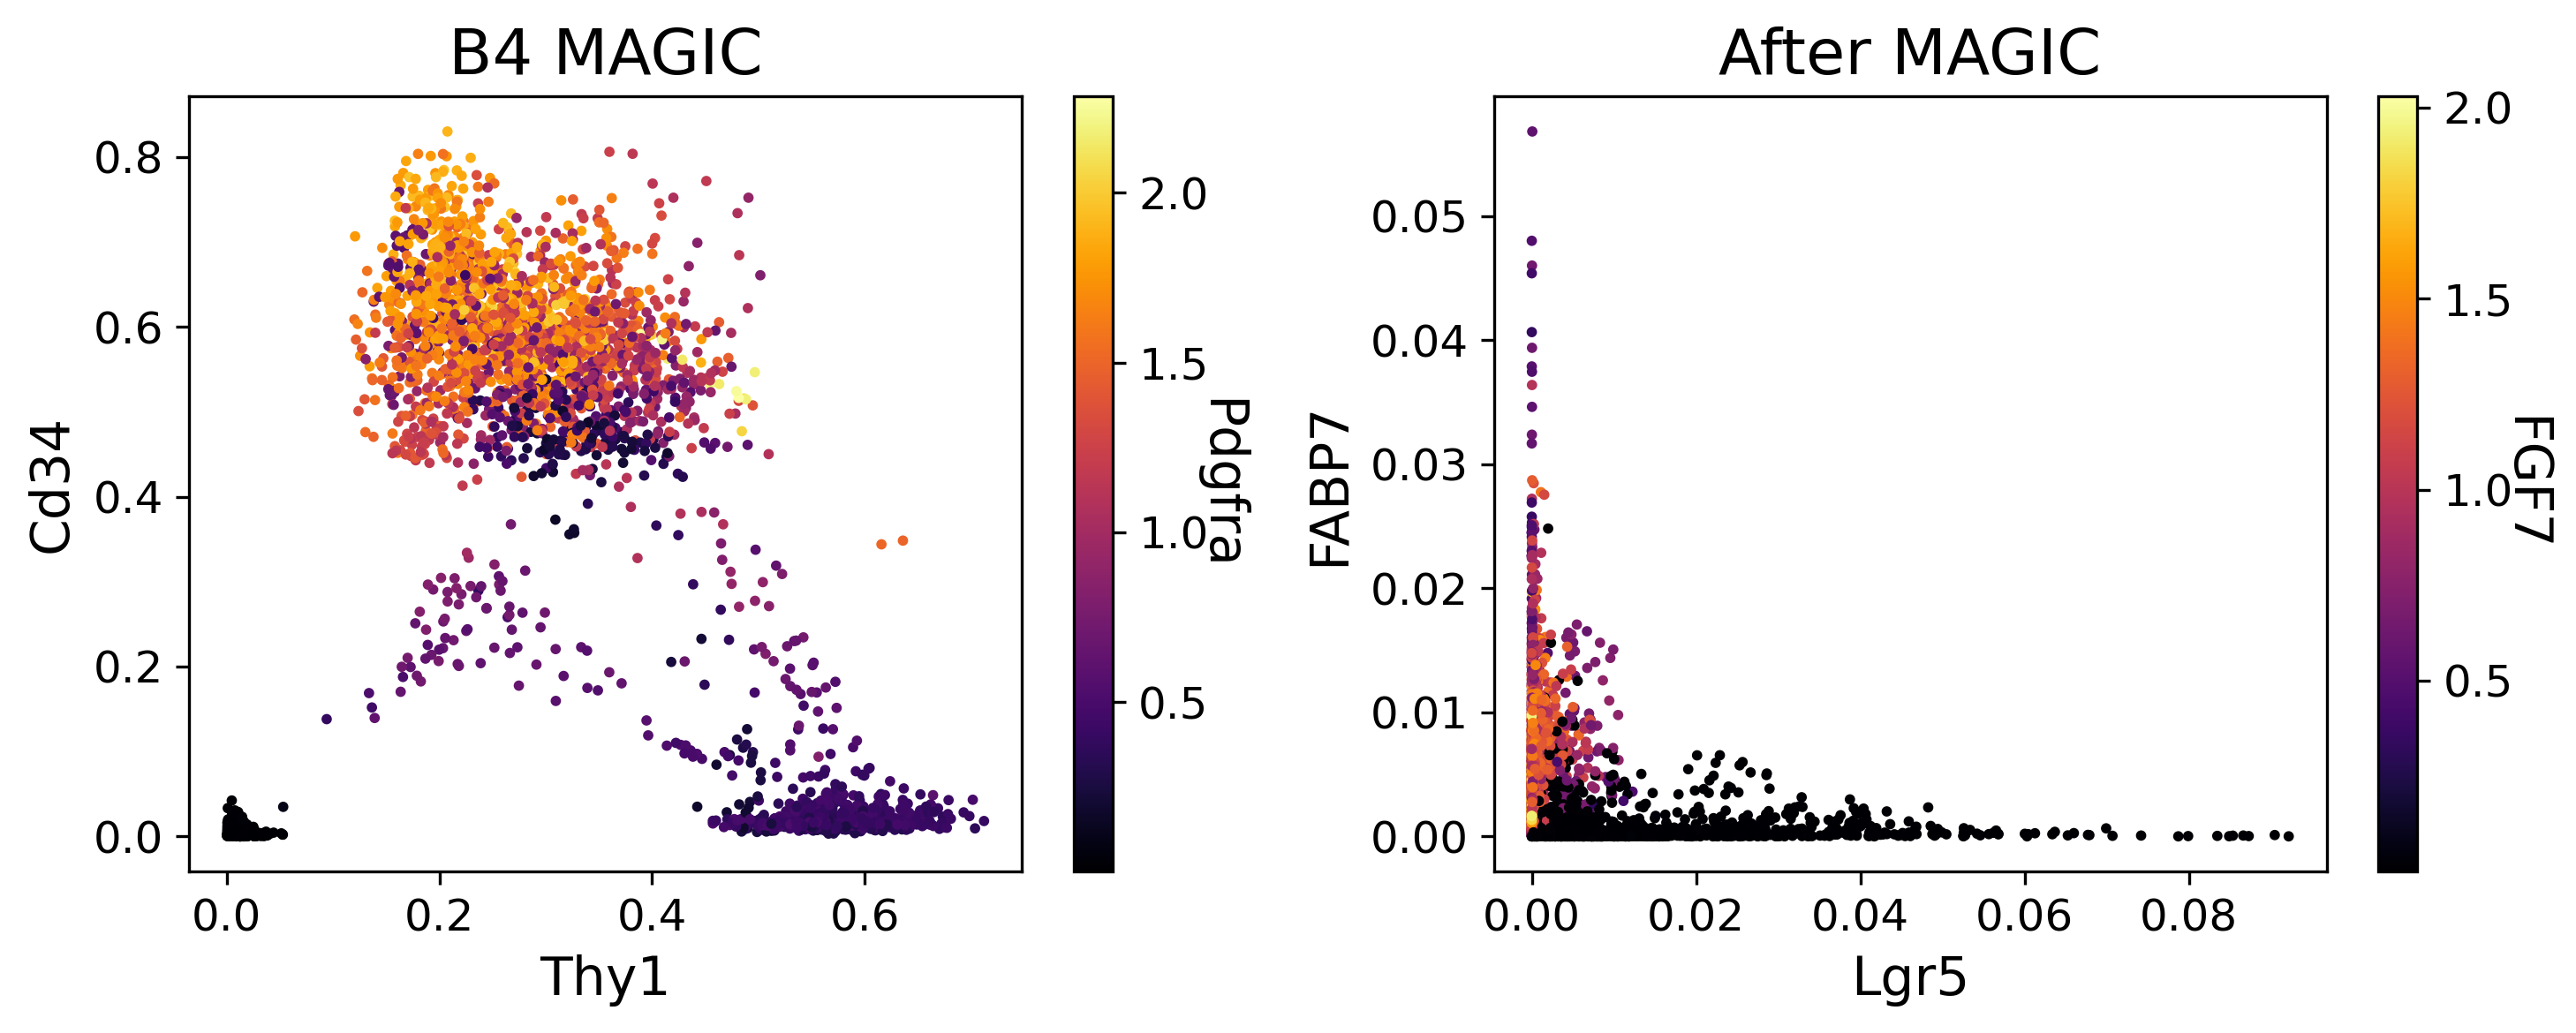

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Thy1"]], y=dMagicRnaSeq[mouse2human["Cd34"]], 
    c=dMagicRnaSeq[mouse2human["Pdgfra"]],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Lgr5"]], y=dMagicRnaSeq["FABP7"], 
    c=dMagicRnaSeq["FGF7"],
    xlabel="Lgr5", ylabel="FABP7", legend_title="FGF7", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

In [15]:
dKGnn = pd.read_csv(f"{data_dir}/dKGnn3.csv.tar.gz", header=None)
dKGnn

,0,1,2
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
16155,R-HSA-5683057,Path2Gene,NEFL
16156,R-HSA-9716542,Path2Gene,MYO19
16157,R-HSA-2262752,Path2Gene,RPS4Y2
16158,R-HSA-2262752,Path2Gene,SCO2


In [16]:
G = networkx.from_pandas_edgelist(dKGnn, source=0,target=2,edge_attr=1)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
    networkx.number_of_isolates(G))
print("The graph is connected:",
    networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

Graph with 3241 nodes and 16086 edges, with a density of 0.0030637548996080314
We have this many isolates:  0
The graph is connected: False

We have 24 connected subgraphs
Component 1: Graph with 3177 nodes and 16043 edges, with a density of 0.003179932274558401
Component 2: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 3: Graph with 3 nodes and 2 edges, with a density of 0.6666666666666666
Component 4: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 5: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 6: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 7: Graph with 1 nodes and 1 edges, with a density of 0
Component 8: Graph with 4 nodes and 4 edges, with a density of 0.6666666666666666
Component 9: Graph with 3 nodes and 2 edges, with a density of 0.6666666666666666
Component 10: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 11: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 12: Graph wi

/tmp/ipykernel_3420/2177202106.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
/tmp/ipykernel_3420/2177202106.py:14: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")


In [17]:
modelKGE = "KGnn3_50_unstratified_stopped_transe"

try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
dKGEnn_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values())#.drop(index=["nan"])
dKGEnn_50

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A2M,-0.053554,-0.178985,-0.080999,0.049027,0.026272,-0.084258,-0.163123,-0.113619,0.268923,-0.208954,...,0.053852,-0.210826,-0.132390,0.092237,0.032694,0.192959,0.230091,0.184533,-0.230351,-0.028134
AAMP,-0.025667,0.020456,0.218393,-0.123198,0.189166,-0.181526,-0.044051,-0.009693,-0.212554,-0.066949,...,0.080953,-0.051854,-0.012305,-0.025745,-0.078264,-0.089182,-0.156475,0.144041,0.129206,-0.195038
AANAT,0.127708,0.018612,0.223402,-0.109907,0.084592,-0.012878,-0.131725,-0.135476,-0.064195,0.069801,...,0.127383,-0.213000,0.215762,0.165453,-0.154380,0.242484,-0.023451,0.162363,0.037533,-0.191141
ABCA1,-0.190185,-0.218391,-0.163101,0.142153,-0.205167,0.099994,-0.029619,-0.142601,0.035681,-0.086018,...,0.080861,-0.175336,0.239642,0.172255,-0.029473,-0.225203,-0.165391,0.070404,0.062336,0.223199
ABCA7,0.161325,-0.106468,-0.154496,0.194961,-0.140460,-0.088964,-0.026563,-0.171441,0.034741,0.095704,...,0.152261,0.176396,-0.059251,-0.004244,-0.171848,0.009871,-0.069714,0.015492,0.102033,-0.106707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZP3,-0.162720,0.064847,0.090790,0.087162,0.076893,0.074385,-0.251694,0.014384,0.144629,0.211467,...,-0.048028,-0.049411,-0.134979,-0.104413,0.091476,-0.152573,0.199232,-0.157363,0.187840,-0.156345
ZRANB1,0.220489,0.186027,-0.124158,0.116860,-0.233124,0.104532,-0.176586,0.010304,0.145687,-0.204371,...,-0.053922,0.192988,-0.200330,0.167393,0.144731,-0.028773,0.065506,0.155197,-0.017460,-0.053715
ZW10,0.217847,0.182367,0.161796,0.075403,-0.207561,0.248680,0.162797,0.179560,0.006216,-0.036367,...,0.089990,0.049248,-0.001284,0.200504,-0.222075,0.136426,-0.008707,0.063070,0.174318,0.040744
ZWILCH,-0.007694,-0.278500,-0.231496,-0.131543,-0.046630,-0.195850,-0.111457,0.165388,-0.033477,-0.143905,...,-0.173107,-0.210659,-0.103348,-0.044696,-0.279335,-0.106196,0.108347,0.198235,-0.044944,-0.070245


## Match genes in KG and scRNA-seq

In [18]:
dMagicRnaSeq = dMagicRnaSeq.reindex(columns=list(G.nodes()), fill_value=float("0"))
dMagicRnaSeq

,CXCL1,CXCR2,CXCL2,CXCL3,CXCL5,PPBP,CXCL6,CXCL8,CXCR1,CXCL9,...,PRAG1,TUBGCP5,PSMB3,PIK3R6,PIP4K2B,NEFL,MYO19,RPS4Y2,SCO2,ARHGAP11B
WT__AAACCCACAGCTTCCT-1,0.0,0.0,0.0,0.0,0.0,0.000039,0.088863,0.0,0.0,0.000398,...,0.021370,0.209528,1.556602,0.0,0.075216,0.0,0.015456,0.0,0.224027,0.011021
WT__AAACCCAGTTCGAGCC-1,0.0,0.0,0.0,0.0,0.0,0.000002,0.038959,0.0,0.0,0.001529,...,0.016969,0.234146,1.662444,0.0,0.055685,0.0,0.016931,0.0,0.220098,0.050136
WT__AAACGAAAGAAGGATG-1,0.0,0.0,0.0,0.0,0.0,0.000611,0.183862,0.0,0.0,0.000243,...,0.009495,0.156987,1.625225,0.0,0.034702,0.0,0.012126,0.0,0.219896,0.011387
WT__AAACGAAAGGAAAGGT-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.006177,0.0,0.0,0.000000,...,0.093526,0.006305,1.138619,0.0,0.002357,0.0,0.004067,0.0,0.090751,0.048338
WT__AAACGAAAGTTAACGA-1,0.0,0.0,0.0,0.0,0.0,0.011418,0.105825,0.0,0.0,0.001730,...,0.102065,0.029861,1.643588,0.0,0.020875,0.0,0.008614,0.0,0.097092,0.025829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.012425,0.0,0.0,0.000000,...,0.013232,0.001933,1.368005,0.0,0.017093,0.0,0.002103,0.0,0.049610,0.024153
WT__TTTGGTTTCCGTAGTA-1,0.0,0.0,0.0,0.0,0.0,0.000002,0.041225,0.0,0.0,0.000640,...,0.026727,0.211930,1.385211,0.0,0.051076,0.0,0.029482,0.0,0.222195,0.008081
WT__TTTGTTGTCGCTTGAA-1,0.0,0.0,0.0,0.0,0.0,0.000761,0.018455,0.0,0.0,0.000000,...,0.117726,0.015730,1.372700,0.0,0.007657,0.0,0.015318,0.0,0.062247,0.031783
WT__TTTGTTGTCTGAATCG-1,0.0,0.0,0.0,0.0,0.0,0.001800,0.189658,0.0,0.0,0.009393,...,0.022007,0.109217,1.692975,0.0,0.035582,0.0,0.009858,0.0,0.218646,0.014780


# Process scRNA data

### Scale MAGIC normalised data

In [19]:
#Cell-scalled GEX:
dScalRnaSeq = dMagicRnaSeq.div(dMagicRnaSeq.sum(axis=1), axis=0)
del dMagicRnaSeq
dScalRnaSeq

,CXCL1,CXCR2,CXCL2,CXCL3,CXCL5,PPBP,CXCL6,CXCL8,CXCR1,CXCL9,...,PRAG1,TUBGCP5,PSMB3,PIK3R6,PIP4K2B,NEFL,MYO19,RPS4Y2,SCO2,ARHGAP11B
WT__AAACCCACAGCTTCCT-1,0.0,0.0,0.0,0.0,0.0,5.949723e-08,0.000136,0.0,0.0,6.091308e-07,...,0.000033,0.000321,0.002382,0.0,0.000115,0.0,0.000024,0.0,0.000343,0.000017
WT__AAACCCAGTTCGAGCC-1,0.0,0.0,0.0,0.0,0.0,3.252348e-09,0.000057,0.0,0.0,2.246750e-06,...,0.000025,0.000344,0.002444,0.0,0.000082,0.0,0.000025,0.0,0.000324,0.000074
WT__AAACGAAAGAAGGATG-1,0.0,0.0,0.0,0.0,0.0,9.451210e-07,0.000284,0.0,0.0,3.754229e-07,...,0.000015,0.000243,0.002513,0.0,0.000054,0.0,0.000019,0.0,0.000340,0.000018
WT__AAACGAAAGGAAAGGT-1,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000012,0.0,0.0,0.000000e+00,...,0.000180,0.000012,0.002195,0.0,0.000005,0.0,0.000008,0.0,0.000175,0.000093
WT__AAACGAAAGTTAACGA-1,0.0,0.0,0.0,0.0,0.0,1.924425e-05,0.000178,0.0,0.0,2.915876e-06,...,0.000172,0.000050,0.002770,0.0,0.000035,0.0,0.000015,0.0,0.000164,0.000044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000022,0.0,0.0,0.000000e+00,...,0.000024,0.000003,0.002434,0.0,0.000030,0.0,0.000004,0.0,0.000088,0.000043
WT__TTTGGTTTCCGTAGTA-1,0.0,0.0,0.0,0.0,0.0,3.275592e-09,0.000063,0.0,0.0,9.754572e-07,...,0.000041,0.000323,0.002113,0.0,0.000078,0.0,0.000045,0.0,0.000339,0.000012
WT__TTTGTTGTCGCTTGAA-1,0.0,0.0,0.0,0.0,0.0,1.359402e-06,0.000033,0.0,0.0,0.000000e+00,...,0.000210,0.000028,0.002451,0.0,0.000014,0.0,0.000027,0.0,0.000111,0.000057
WT__TTTGTTGTCTGAATCG-1,0.0,0.0,0.0,0.0,0.0,2.604212e-06,0.000274,0.0,0.0,1.358578e-05,...,0.000032,0.000158,0.002449,0.0,0.000051,0.0,0.000014,0.0,0.000316,0.000021


# Wavelet dictionaries

In [20]:
print(pygsp.__version__)

pyG = pygsp.graphs.Graph(W=networkx.to_numpy_array(G))
wavloc = Localizer(pyG) #Takes only pygsp graphs
wavloc.CalculateWavelets(J=6) #J is the scale param. With v2 we get !div() and nans
wavloc.FlattenAndNormalize()
print(wavloc.FlatWaves.shape)
wavloc.FlatWaves

2022-10-12 14:32:53,066:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


0.5.1
Calculating Wavelets Using J = 6


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


Flattening and Normalizing Wavelets


 17%|█▋        | 1/6 [00:00<00:01,  4.24it/s]/gpfs/ysm/home/fc489/yaleCollab/localization.py:141: RuntimeWarning: invalid value encountered in divide
  A[:,i]=A[:,i]/np.linalg.norm(A[:,i])
100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

(3241, 19446)


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.06378788e-05, -8.06378788e-05, -1.20596253e-04],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -1.47351726e-03, -1.47351726e-03, -1.93840712e-03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -3.29480286e-03, -3.29480286e-03, -4.58429468e-03],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.41163271e-03,  3.24199049e-03, -3.49698768e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.24199049e-03,  3.41163271e-03, -3.49698768e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.93673033e-04, -3.93673033e-04,  2.60852779e-03]])

In [21]:
#Multiply 2 matrices using the dot product
cell_projection = np.dot(dScalRnaSeq, wavloc.FlatWaves)
del wavloc
del pyG
print(cell_projection.shape) #Shape should be cellsXwavelets
cell_projection

(3698, 19446)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.76472344e-04,  9.76530491e-04, -2.60709830e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.73989828e-04,  9.74044711e-04, -2.35543258e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.49474217e-04,  9.49531898e-04, -2.71930438e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.08413610e-04,  9.08432466e-04, -6.54284623e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.53488367e-04,  8.53542017e-04, -2.28584801e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.02103769e-03,  1.02108160e-03, -1.27223431e-04]])

In [23]:
#Save to file as compressed npy object
np.savez_compressed(f"{data_dir}/cell_projection_KGnn3WAV.npz", cell_projection)

In [30]:
cell_projection = np.load(f"{data_dir}/cell_projection_KGnn3WAV.npz")["arr_0"]#Dict-like struct.Default arr_N keys
print(cell_projection.shape) #Shape should be cellsXwavelets
cell_projection

(3698, 43920)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.97674506e-04, -2.97674506e-04,  2.69178595e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.00076027e-04, -3.00076027e-04,  1.17030665e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.01058520e-04, -3.01058520e-04,  3.99406380e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.60973436e-04, -2.60973436e-04, -1.88515992e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.97307391e-04, -2.97307391e-04, -1.61231252e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.93550266e-04, -2.93550266e-04, -2.25084958e-05]])

In [26]:
print(np.isnan(np.sum(cell_projection)))
from sklearn.impute import SimpleImputer
cell_projection = SimpleImputer(strategy="constant").fit_transform(cell_projection)
print(np.isnan(np.sum(cell_projection)))

True
False


### Downstream 

In [27]:
data_phate = phate.PHATE().fit_transform(cell_projection) 

Calculating PHATE...
  Running PHATE on 3698 observations and 19446 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.14 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.57 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 2.74 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.15 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.24 seconds.
  Calculated landmark operator in 4.45 seconds.
  Calculating optimal t...
    Automatically selected t = 39
  Calculated optimal t in 0.84 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.21 seconds.
Calculated PHATE in 12.76 seconds.


<AxesSubplot: title={'center': 'Cells on communication KG (col=FABP2)'}>

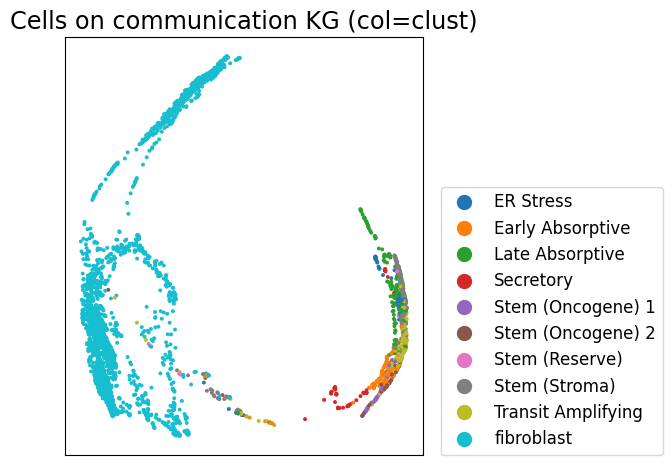

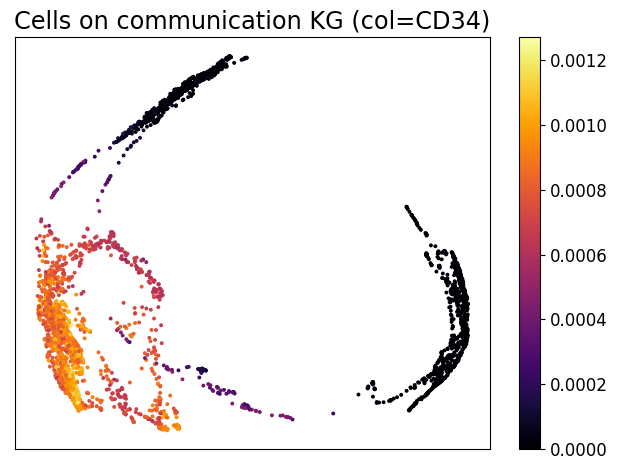

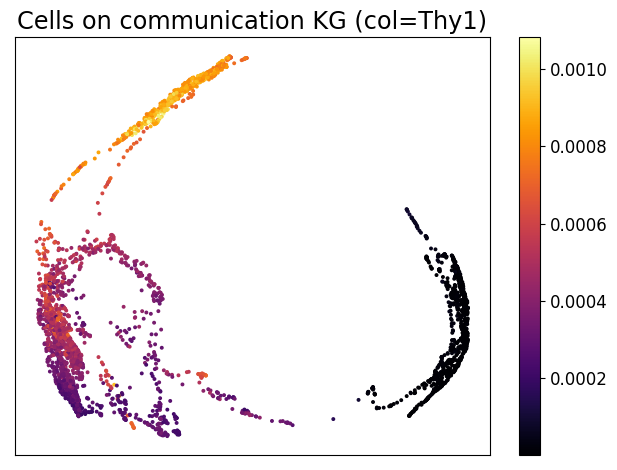

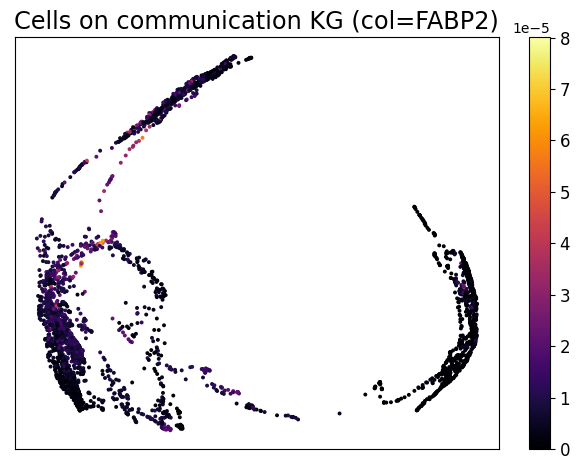

In [29]:
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))

scprep.plot.scatter2d(
    data_phate, c=dScalRnaSeq["CD34"],
    title="Cells on communication KG (col=CD34)", ticks=None,
    legend_loc=(1.05, 0))
scprep.plot.scatter2d(
    data_phate, c=dScalRnaSeq["THY1"],
    title="Cells on communication KG (col=Thy1)", ticks=None,
    legend_loc=(1.05, 0))

scprep.plot.scatter2d(
    data_phate, c=dScalRnaSeq["FABP7"],
    title="Cells on communication KG (col=FABP2)", ticks=None,
    legend_loc=(1.05, 0))


PHATE embedding is still very, very similar to the other KG.
Scale parameter does seem to change the topology quite a bit, with higher values than 4 appearing a bit "mesier", which sometimes does puet pops like Late and early enterocytes closer together.